<a href="https://colab.research.google.com/github/s17009/PAD/blob/main/Trash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install google-cloud-vision
#pip install Pillow
#pip install piexif
#pip install selenium
#pip install folium
#pip install matplotlib


In [ ]:
from google.cloud import vision

In [ ]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS']='C:/Users/Patryk/Desktop/deft-station-375717-6847447a0df3.json'

In [ ]:
def detect_labels_uri(uri):
    """Detects labels in the file located in Google Cloud Storage or on the
    Web."""
    from google.cloud import vision
    client = vision.ImageAnnotatorClient()
    image = vision.Image()
    image.source.image_uri = uri

    response = client.label_detection(image=image)
    labels = response.label_annotations
    #print(labels)
    print('Labels:')

    for label in labels:
        print(label.description + " "+ str(label.score))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
                
def detect_labels(path):
    """Detects labels in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    response = client.label_detection(image=image)
    labels = response.label_annotations
    print('Labels:')

    for label in labels:
        print(label.description+ " "+ str(label.score))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [ ]:
#detect_labels_uri('https://www.ladysmithchronicle.com/wp-content/uploads/2019/07/17648894_web1_190711-LCH-Garbage-Forests1-640x427.jpg')
detect_labels('C:/Users/Patryk/Desktop/trash_gps (1).jpg')

Labels:
Natural material 0.8680601119995117
Wood 0.8678838610649109
Plant 0.8398303389549255
Twig 0.8374840617179871
Pollution 0.8302095532417297
Grass 0.8187978267669678
Groundcover 0.7889887094497681
Grass family 0.7555104494094849
Waste 0.7441276907920837
Electric blue 0.708453893661499


In [ ]:
contours = []

In [ ]:
def localize_objects_uri(uri):
    """Localize objects in the image on Google Cloud Storage

    Args:
    uri: The path to the file in Google Cloud Storage (gs://...)
    """
    from google.cloud import vision
    client = vision.ImageAnnotatorClient()

    image = vision.Image()
    image.source.image_uri = uri

    objects = client.object_localization(
        image=image).localized_object_annotations

    print('Number of objects found: {}'.format(len(objects)))
    for object_ in objects:
        print('\n{} (confidence: {})'.format(object_.name, object_.score))
        print('Normalized bounding polygon vertices: ')
        for vertex in object_.bounding_poly.normalized_vertices:
            print(' - ({}, {})'.format(vertex.x, vertex.y))
            
def localize_objects(path):
    """Localize objects in the local image.

    Args:
    path: The path to the local file.
    """
    from google.cloud import vision
    client = vision.ImageAnnotatorClient()

    with open(path, 'rb') as image_file:
        content = image_file.read()
    image = vision.Image(content=content)

    objects = client.object_localization(
        image=image).localized_object_annotations

    print('Number of objects found: {}'.format(len(objects)))
    for object_ in objects:
        print('\n{} (confidence: {})'.format(object_.name, object_.score))
        print('Normalized bounding polygon vertices: ')
        for vertex in object_.bounding_poly.normalized_vertices:
            print(' - ({}, {})'.format(vertex.x, vertex.y))
            if(object_.name in ['Bottle','Packaged goods',]):
                contours.append([vertex.x,vertex.y])

In [ ]:
#localize_objects_uri('https://www.ladysmithchronicle.com/wp-content/uploads/2019/07/17648894_web1_190711-LCH-Garbage-Forests1-640x427.jpg')
localize_objects('C:/Users/Patryk/Desktop/trash_gps (1).jpg')

Number of objects found: 1

Bottle (confidence: 0.8042235374450684)
Normalized bounding polygon vertices: 
 - (0.2776903510093689, 0.3776628077030182)
 - (0.7477076053619385, 0.3776628077030182)
 - (0.7477076053619385, 0.7094628810882568)
 - (0.2776903510093689, 0.7094628810882568)


In [ ]:
print(contours)

[[0.2776903510093689, 0.3776628077030182], [0.7477076053619385, 0.3776628077030182], [0.7477076053619385, 0.7094628810882568], [0.2776903510093689, 0.7094628810882568]]


In [ ]:
import cv2
import numpy as np

img = cv2.imread('C:/Users/Patryk/Desktop/trash_gps (1).jpg')

a, b, c = img.shape

x = int(contours[0][0]*b)
y = int(contours[0][1]*a)
w = int(contours[2][0]*b)
h = int(contours[2][1]*a)

cv2.rectangle(img, (x, y), (w,h), (0, 0, 255), 2)

# save resulting image
cv2.imwrite('C:/Users/Patryk/Desktop/trash_gps (1)_result.jpg',img)      #zdj z ramkami


170
x,y,w,h: 170 130 459 244


True

In [ ]:
from PIL import Image
from PIL.ExifTags import TAGS

In [ ]:
imagename = "C:/Users/Patryk/Desktop/trash_gps (1).jpg"
#https://drive.google.com/file/d/1i0hYkcI7nN4fPDAuEhJolDFU7mfm7kBB/view?usp=share_link zdj z lokalizacją gps w metadanych

# read the image data using PIL
image = Image.open(imagename)

In [ ]:
import piexif

codec = 'ISO-8859-1'

def exif_to_tag(exif_dict):
    exif_tag_dict = {}
    thumbnail = exif_dict.pop('thumbnail')
    exif_tag_dict['thumbnail'] = thumbnail.decode(codec)

    for ifd in exif_dict:
        exif_tag_dict[ifd] = {}
        for tag in exif_dict[ifd]:
            try:
                element = exif_dict[ifd][tag].decode(codec)

            except AttributeError:
                element = exif_dict[ifd][tag]

            exif_tag_dict[ifd][piexif.TAGS[ifd][tag]["name"]] = element

    return exif_tag_dict

In [ ]:
exif_dict = piexif.load(image.info.get('exif'))
exif_dict = exif_to_tag(exif_dict)
print(exif_dict['GPS'])

{'GPSLatitudeRef': 'N', 'GPSLatitude': ((52, 1), (88090983, 10000000), (0, 1)), 'GPSLongitudeRef': 'E', 'GPSLongitude': ((20, 1), (542500939, 10000000), (0, 1))}


In [ ]:
#Wysokosc i szerokosc geograficzna pobrana z metadanych zdj
lat = float(str(exif_dict['GPS'].get('GPSLatitude')[0][0])+"."+str(exif_dict['GPS'].get('GPSLatitude')[1][0]))
long = float(str(exif_dict['GPS'].get('GPSLongitude')[0][0])+"."+str(exif_dict['GPS'].get('GPSLongitude')[1][0]))
print(lat)
print(long)

52.88090983
20.542500939


In [ ]:
# import the library
import folium

# Make an empty map
m = folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=2)

# Show the map
m

In [ ]:
folium.Marker(location=[lat, long],).add_to(m)

In [ ]:
wartosc = 1
m.fit_bounds([[lat-wartosc,long-wartosc], [lat+wartosc,long+wartosc]]) 

In [ ]:
import io
from PIL import Image

img_data = m._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('image.png')

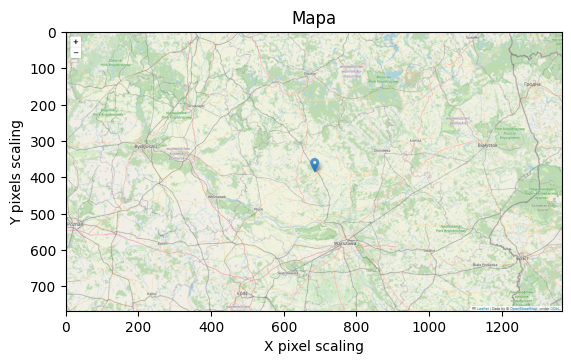

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
 
plt.title("Mapa")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")

plt.imshow(img)
plt.show()